# Assignment 6: Group 1

## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble.gradient_boosting import train_test_split

import os
import time
import datetime

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

import kerastuner as kt
import IPython

## Import Data

In [2]:
#Importing the Data
digit_data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

## Split Training data, create Validation set, and Scale the data

In [3]:
(X_train,X_val) = train_test_split(digit_data, test_size=.1)
y_train = X_train['label']
y_val = X_val['label']
X_train = X_train.drop('label', axis=1) / 255.0
X_val = X_val.drop('label', axis=1) / 255.0
X_test = X_test / 255.0

In [4]:
X_train.shape

(37800, 784)

In [4]:
class_names = [0,1,2,3,4,5,6,7,8,9]

## Building a classification MLP with 2 & 5 hidden layers using Sequential API

In [6]:
model = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model1 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(1000,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model2 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(500,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model3 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model4 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])

models = [model,model1,model2,model3,model4]

## Compiling the model

In [7]:
for m in models:
    m.compile(loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'])

## Creating & saving the best checkpoints during training

In [8]:
checkpoints = []
times = []
i = 0
for m in models:
    checkpoint_cb = keras.callbacks.ModelCheckpoint(f'my_keras_model{i}.h5', save_best_only=True)
    start_time = datetime.datetime.now()
    m.fit(X_train,y_train,
        epochs=40,
        validation_data=(X_val,y_val), callbacks=[checkpoint_cb])
    end_time = datetime.datetime.now()
    times.append(end_time-start_time)
    i+=1

3/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0416 - accuracy: 0.9904 - val_loss: 0.0933 - val_accuracy: 0.9748
Epoch 24/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0392 - accuracy: 0.9912 - val_loss: 0.0833 - val_accuracy: 0.9771
Epoch 25/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0368 - accuracy: 0.9917 - val_loss: 0.0828 - val_accuracy: 0.9781
Epoch 26/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0342 - accuracy: 0.9929 - val_loss: 0.0862 - val_accuracy: 0.9752
Epoch 27/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0323 - accuracy: 0.9933 - val_loss: 0.0820 - val_accuracy: 0.9769
Epoch 28/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0302 - accuracy: 0.9941 - val_loss: 0.0799 - val_accuracy: 0.9795
Epoch 29/40
1182/1182 [==============================] - 4s 3ms/step - loss: 0.0284 - accuracy: 0.9945 - val_loss: 0.0812 - val_accuracy:

## Plotting Learning Curves for each model

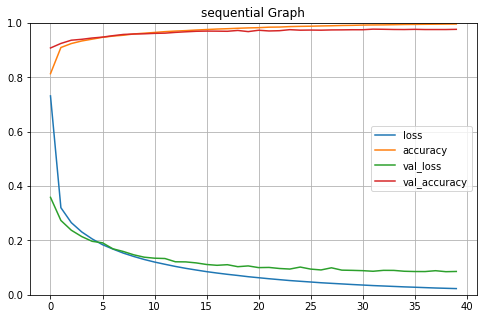

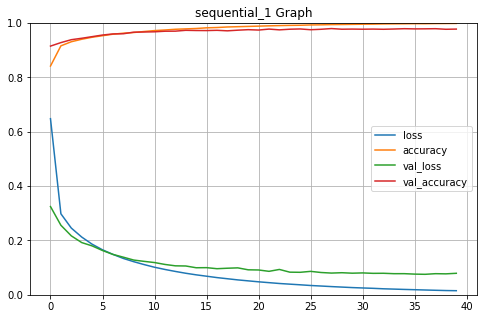

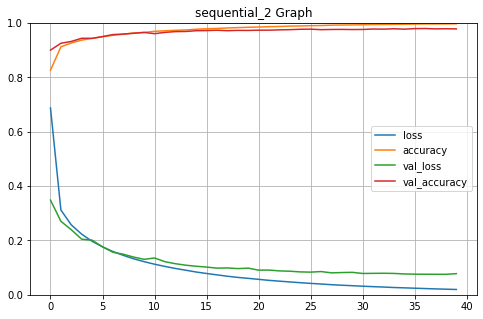

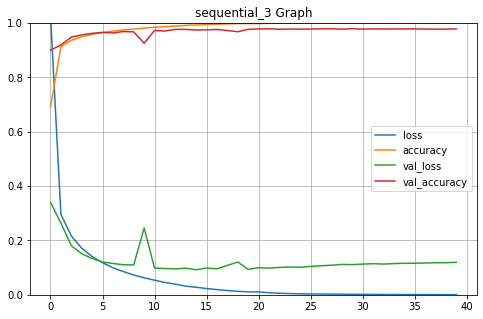

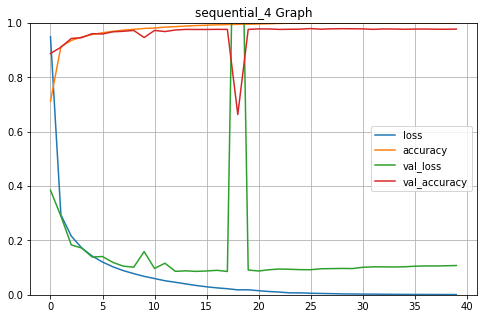

In [9]:
for m in models:
    pd.DataFrame(m.history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.title(f'{m._name} Graph')
plt.savefig('sequential_graphs.png')

In [10]:
losses = []
tst_losses = []
accuracys = []
tst_accuracys = []
for m in models:
    (loss,acc) = m.evaluate(X_train,y_train)
    (tst_loss,tst_acc) = m.evaluate(X_val, y_val)
    losses.append(loss)
    tst_losses.append(tst_loss)
    accuracys.append(acc)
    tst_accuracys.append(tst_acc)


132/132 [==============================] - 0s 705us/step - loss: 0.1077 - accuracy: 0.9776


In [11]:
d = {'model_name': ['1','2','3','4','5'], 
    'nodes_in_layers': [[300,100],[1000,100],[500,100],[300,100,300,100,100],[200,200,200,100,100]],
    'num_layers':[2,2,2,5,5],
    'process_time': times,
    'trng_accr': accuracys,
    'tst_accr': tst_accuracys}
results_df = pd.DataFrame(d)

In [12]:
tst_predictions = []
for m in models:
    test_prediction = m.predict(X_test)
    test_predictions_classes = np.argmax(m.predict(X_test), axis=-1)
    tst_predictions.append(test_predictions_classes)

## Output results

In [13]:
for i in range(len(models)):
    results = pd.DataFrame(tst_predictions[i])
    results.index = np.arange(1, len(results) + 1)
    results.to_csv(f'{i}_model_results.csv')

Lets try a different activation function (selu) and optimizer (adam).

In [14]:
# selu model
model5 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(10,activation='softmax')
])
model5.compile(loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
model5.fit(X_train,y_train, epochs=50,
    validation_data=(X_val,y_val))


Epoch 1/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.3553 - accuracy: 0.8940 - val_loss: 0.3371 - val_accuracy: 0.9088
Epoch 2/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.2079 - accuracy: 0.9390 - val_loss: 0.1963 - val_accuracy: 0.9414
Epoch 3/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1619 - accuracy: 0.9512 - val_loss: 0.1169 - val_accuracy: 0.9631
Epoch 4/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1349 - accuracy: 0.9585 - val_loss: 0.1434 - val_accuracy: 0.9550
Epoch 5/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1152 - accuracy: 0.9663 - val_loss: 0.1529 - val_accuracy: 0.9550
Epoch 6/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1012 - accuracy: 0.9698 - val_loss: 0.1311 - val_accuracy: 0.9652
Epoch 7/50
1182/1182 [==============================] - 2s 2ms/step - loss: 0.0960 - accuracy: 0.9711 - val_loss: 0.1313 - val_accuracy:

In [15]:
(loss,acc) = model5.evaluate(X_train,y_train)
(tst_loss,tst_acc) = m.evaluate(X_val, y_val)
losses.append(loss)
tst_losses.append(tst_loss)
accuracys.append(acc)
tst_accuracys.append(tst_acc)

132/132 [==============================] - 0s 712us/step - loss: 0.1077 - accuracy: 0.9776


In [16]:
results_df = results_df.append({'model_name': 6, 
    'nodes_in_layers':[200,200,200,200,200],
    'num_layers': 5,
    'process_time': times[4],
    'trng_accr': acc,
    'tst_accr': tst_acc}, ignore_index=True)

In [17]:
model5_predictions = np.argmax(model5.predict(X_test), axis=-1)
results = pd.DataFrame(model5_predictions)
results.index = np.arange(1, len(results) + 1)
results.to_csv(f'model5_results.csv')

# Summary
## Kaggle Team Name: Digit Finders


## Data Pre-processing:

We have 42000 images available as training data. 

We have split this data and used 10% as validation data.

Then we have scaled the data and divide the input features by 255.

## Creating model:

We have created 5 models using Sequential API to build the first layer and the Dense output layer with 10 neurons (one for each class) using "softmax" activation function.

1) Model: (2 Layer)
First Dense hidden layer with 300 neurons & using ReLU activation function.
Second Dense hidden layer with 100 neurons & using ReLU activation function. 
   
2) Model1: (2 Layer)
First Dense hidden layer with 1000 neurons & using ReLU activation function. 
Second Dense hidden layer with 100 neurons & using ReLU activation function.
   
3) Model2: (2 Layer)
First Dense hidden layer with 500 neurons & using ReLU activation function. 
Second Dense hidden layer with 100 neurons & using ReLU activation function.
   
4) Model3: (5 Layer)
 First Dense hidden layer with 300 neurons & using ReLU activation function.
 Second Dense hidden layer with 100 neurons & using ReLU activation function.
 Third Dense hidden layer with 300 neurons & using ReLU activation function.
 Fourth Dense hidden layer with 100 neurons & using ReLU activation function.
 Fifth Dense hidden layer with 100 neurons & using ReLU activation function.
   
5) Model4: (5 Layer) 
  First Dense hidden layer with 200 neurons & using ReLU activation function. 
  Second Dense hidden layer with 200 neurons & using ReLU activation function.
  Third Dense hidden layer with 200 neurons & using ReLU activation function.
  Fourth Dense hidden layer with 100 neurons & using ReLU activation function.
  Fifth Dense hidden layer with 100 neurons & using ReLU activation function.

6) Model5: (5 Layer Adam Build)
  First Dense hidden layer with 200 neurons & using SeLU activation function.
  Second Dense hidden layer with 200 neurons & using SeLU activation function.
  Third Dense hidden layer with 200 neurons & using SeLU activation function.
  Fourth Dense hidden layer with 100 neurons & using SeLU activation function.
  Fifth Dense hidden layer with 100 neurons & using SeLU activation function.
7) Model6: Hypertuned Adam Build
  First Dense hidden layer with 352 nuerons & using ReLU activation function.

## Loss Function:

We have chosen the loss function to be "Sparse Categorical Crossentropy" as we have sparse labels and the classes are exclusive & "sgd", which is the Stochastic Gradient Descent as the optimizer for our model and with a default learning rate of 0.01.

## Best model:

Then we have used the "Checkpoint" and saved the best model from amongst the 5 models described above.


## Graphs:

We can see that in the 5 layer model the Validation lossess are higher and the gap with loss starts increasing with each Epoch.

Initial loss is very high in the 5 layer models but rapidly reduces and achieves similar levels as a 2 layer model.

## Results:
Our results were very favorable for relu in the 97th percentile for test accuracy. You can see a representative summary in our results_df dataframe, shown in the next codeblock. While experimenting with RandomSearch Parameters, we ran into a RunTimeError with overriding the build_model variable. We weren't able to overcome this hurdle. We did try selu activation with adam optimizer. This ended up being our highest scoring model. It's our recommendation to management that we spend more time with hyperparameter optimization to allow better tuning of the model for the last 3 percent. I know we can get there. We were tuning the number of hidden layers, the number of neurons and the learning_rate.  I will leave our error'd code attached at the end of this so as to showcase our work on building this build_model method. Please note that the error doesn't become an issue until after a few hundred epochs making it difficult to troublshoot as it would fail an hour into run. Upon further research, it appears that the issue is with the latest package of scipi with no fix (https://github.com/keras-team/keras/issues/13586). 

## Model Accuracy Results

In [18]:
results_df

,model_name,nodes_in_layers,num_layers,process_time,trng_accr,tst_accr
0,1,"[300, 100]",2,00:00:50.198905,0.997328,0.976667
1,2,"[1000, 100]",2,00:02:27.269018,0.998386,0.977619
2,3,"[500, 100]",2,00:01:31.226851,0.997355,0.978333
3,4,"[300, 100, 300, 100, 100]",5,00:01:07.704607,1.000000,0.978333
4,5,"[200, 200, 200, 100, 100]",5,00:01:06.909085,1.000000,0.977619
5,6,"[200, 200, 200, 200, 200]",5,00:01:06.909085,0.987037,0.977619


# keras Tuner - hyperparameter searching

In [33]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=[784]))

    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(Dense(units = hp_units, activation = 'selu', kernel_initializer='lecun_normal'))
    model.add(Dense(10))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2,1e-3,1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'])
    
    return model

In [35]:
tuner = kt.Hyperband(model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor=3,
    directory = 'my_dir',
    project_name = 'selu_kt_tuner')

In [36]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [37]:
tuner.search(X_train,y_train, epochs=10, 
    validation_data = (X_val, y_val),
    callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [40]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.001.



In [42]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs = 10,
    validation_data = (X_val, y_val))

Epoch 1/10
1182/1182 [==============================] - 2s 2ms/step - loss: 0.3452 - accuracy: 0.8981 - val_loss: 0.2861 - val_accuracy: 0.9193
Epoch 2/10
1182/1182 [==============================] - 2s 1ms/step - loss: 0.2126 - accuracy: 0.9359 - val_loss: 0.2029 - val_accuracy: 0.9407
Epoch 3/10
1182/1182 [==============================] - 2s 1ms/step - loss: 0.1406 - accuracy: 0.9581 - val_loss: 0.1427 - val_accuracy: 0.9593
Epoch 4/10
1182/1182 [==============================] - 2s 1ms/step - loss: 0.1032 - accuracy: 0.9684 - val_loss: 0.1376 - val_accuracy: 0.9562
Epoch 5/10
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0799 - accuracy: 0.9754 - val_loss: 0.1311 - val_accuracy: 0.9612
Epoch 6/10
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0642 - accuracy: 0.9797 - val_loss: 0.1140 - val_accuracy: 0.9683
Epoch 7/10
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0519 - accuracy: 0.9835 - val_loss: 0.1177 - val_accuracy:

In [43]:
model.evaluate(X_val,y_val)

132/132 [==============================] - 0s 591us/step - loss: 0.1138 - accuracy: 0.9690


[0.11382539570331573, 0.9690476059913635]

In [44]:
predictions = np.argmax(model.predict(X_test), axis=-1)
results = pd.DataFrame(predictions)
results.index = np.arange(1, len(results) + 1)
results.to_csv(f'keras_tuned_selu_results.csv')

In [23]:
#Build log files and tensorboard callbacks
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)